# Using Keras Models in TF

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

/Users/zach/anaconda3/envs/datalab/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
tf.__version__

'1.4.0'

In [3]:
import numpy as np
RGB_MEAN_PIXELS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)).astype(np.float32)
IMAGE_SHAPE = (200,300)

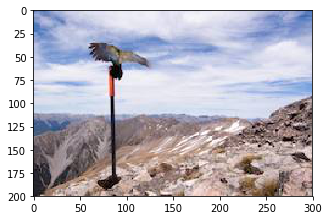

In [4]:
from PIL import Image
import requests
from io import BytesIO

def load_image(url, output_size=IMAGE_SHAPE):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(output_size[::-1])
    return np.asarray(img, dtype=np.float32)

img = load_image('https://github.com/zachmoshe/zachmoshe.com/raw/master/content/use-keras-models-with-tf/newzealand.jpg')
plt.figure(figsize=(5,5))
plt.imshow(img/255.)

# Pure Keras Example

In [5]:
import keras
print(keras.__version__)

vgg19 = keras.applications.VGG19(weights='imagenet', include_top=False)
img_input = np.expand_dims(img,0)
keras_output = vgg19.predict(np.flip(img_input-RGB_MEAN_PIXELS, axis=-1))  # applying VGG preprocessing 

Using TensorFlow backend.


2.0.8


In [7]:
keras_output.shape, keras_output.mean()

((1, 6, 9, 512), 1.5227494)

# A naive approach to integrate Keras and Tensorflow

In [8]:
input_img = tf.placeholder(tf.float32, (1,200,300,3), name='input_img')
vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
output = vgg19(input_img)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_val = sess.run(output, {input_img: np.expand_dims(img,0)})

output_val.shape, output_val.mean()

((1, 6, 9, 512), 0.067449108)

# VGG19 object can't be used in another session

Or we get: 
```
Attempting to use uninitialized value block1_conv1/bias
```


In [9]:
# Here we're not in a session - Keras will create one for itself.
vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
print(vgg19.get_layer('block1_conv1').get_weights()[0].shape)
print("Everything was loaded as we would expect")
print() 
  
# And now in a new session - an ERROR will be raised as no-one initialized the weights (the ctr. did it 
# before but in another session)
with tf.Session().as_default():
    try:
        print(vgg19.get_layer('block1_conv1').get_weights()[0][:,:,:,0])
    except Exception as ex:
        print("EXCEPTION: ", ex)


(3, 3, 3, 64)
Everything was loaded as we would expect

EXCEPTION:  Attempting to use uninitialized value block1_conv1_1/bias
	 [[Node: _retval_block1_conv1_1/bias_0_0 = _Retval[T=DT_FLOAT, index=0, _device="/job:localhost/replica:0/task:0/device:CPU:0"](block1_conv1_1/bias)]]


# tf.global_variables_initializer() will destroy pre-train weights

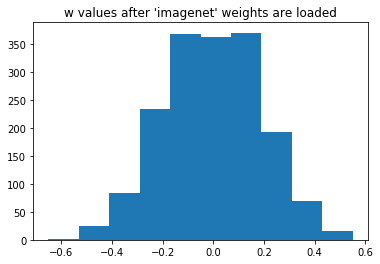

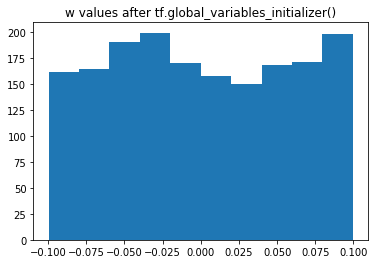

In [10]:
with tf.Session() as sess:
    vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
    w = vgg19.get_layer('block1_conv1').get_weights()[0]
    plt.hist(w.flatten())
    plt.title("w values after 'imagenet' weights are loaded")
    plt.show()
    
    sess.run(tf.global_variables_initializer())
    w = vgg19.get_layer('block1_conv1').get_weights()[0]
    plt.hist(w.flatten())
    plt.title("w values after tf.global_variables_initializer()")
    plt.show()
    


# Use input_tensor in VGG19 constructor

instead of vgg19(input_tensor).

Ipython notebook graph code was taken from - https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter

In [7]:
from IPython.display import display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [12]:
keras_way_graph = tf.Graph()
with keras_way_graph.as_default(), tf.Session().as_default():
    input_img = tf.placeholder(tf.float32, (1,224,224,3), name='input_image')
    vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
    output = vgg19(input_img)
    
right_way_graph = tf.Graph()
with right_way_graph.as_default(), tf.Session().as_default():
    input_img = tf.placeholder(tf.float32, (1,224,224,3), name='input_image')
    vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=input_img)
    output = tf.identity(vgg19.layers[-1].output, name='output')
    
show_graph(keras_way_graph.as_graph_def())
show_graph(right_way_graph.as_graph_def())


# Using my VGG19 class

In [5]:
import numpy as np
import tensorflow as tf
import tempfile

RGB_MEAN_PIXELS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)).astype(np.float32)
DEFAULT_IMAGE_SHAPE = (1,224,224,3)

class VGG19():
    """
    A class that builds a TF graph with a pre-trained VGG19 model (on imagenet)
    Also takes care of preprocessing. Input should be a regular RGB image (0-255)
    """
    def __init__(self, image_shape=DEFAULT_IMAGE_SHAPE, input_tensor=None):
        self.image_shape = image_shape
        self._build_graph(input_tensor)

    def _build_graph(self, input_tensor):
        with tf.Session() as sess:
            with tf.variable_scope('VGG19'):
                with tf.name_scope('inputs'):
                    if input_tensor is None:
                        input_tensor = tf.placeholder(tf.float32, shape=self.image_shape, name='input_img')
                    else:
                        assert self.image_shape == input_tensor.shape
                    self.input_tensor = input_tensor

                with tf.name_scope('preprocessing'):
                    img = self.input_tensor - RGB_MEAN_PIXELS
                    img = tf.reverse(img, axis=[-1])

                with tf.variable_scope('model'):
                    self.vgg19 = tf.keras.applications.VGG19(weights='imagenet',
                        include_top=False, input_tensor=img)

                self.outputs = { l.name: l.output for l in self.vgg19.layers }

            self.vgg_weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='VGG19/model')
            
            with tempfile.NamedTemporaryFile() as f:
                self.tf_checkpoint_path = tf.train.Saver(self.vgg_weights).save(sess, f.name)

        self.model_weights_tensors = set(self.vgg_weights)


    def load_weights(self):
        sess = tf.get_default_session()
        tf.train.Saver(self.vgg_weights).restore(sess, self.tf_checkpoint_path)

    def __getitem__(self, key):
        return self.outputs[key]


In [8]:
tf.reset_default_graph()

my_img = tf.placeholder(tf.float32, (1,200,300,3), name='my_original_image')
vgg = VGG19(image_shape=(1,200,300,3), input_tensor=my_img)

output = tf.identity(vgg['block5_pool'], name='my_output')

show_graph(tf.get_default_graph().as_graph_def())

In [9]:
with tf.Session() as sess:
    vgg.load_weights()
    fd = { my_img: np.expand_dims(img,0) }

    output_val = sess.run(output, fd)

INFO:tensorflow:Restoring parameters from /var/folders/ws/cpz40kp14qvb0b7fwjn224380000gn/T/tmpah_hdous


In [10]:
print(output_val.shape, output_val.mean())

(1, 6, 9, 512) 1.52275


# Model weights are trainable

In [11]:
trainable_weights_graph = tf.Graph()

with trainable_weights_graph.as_default():
    var_image = tf.Variable(tf.random_normal((1,224,224,3), stddev=0.01, dtype=tf.float32), name='var_image')
    vgg = VGG19(image_shape=(1,224,224,3), input_tensor=var_image)
    vgg_output = vgg['block5_pool']
    desired_output = tf.ones(shape=vgg_output.shape)
    loss = tf.reduce_mean(tf.square(vgg_output - desired_output))
    
    opt = tf.train.GradientDescentOptimizer(0.01)
    train_op = opt.minimize(loss)
    
    non_vgg_vars = list(set(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)) - vgg.model_weights_tensors)
    train_op_no_vgg = opt.minimize(loss, var_list=non_vgg_vars)


In [12]:
with tf.Session(graph=trainable_weights_graph) as sess:
    print("First Round - using the regular train_op:")
    print("-----------------------------------------")
    sess.run(tf.global_variables_initializer())
    vgg.load_weights()
    
    print("{:5} {:20} {:20} {:20}".format('ITER', 'LOSS', 'SUM(WEIGHTS)', 'SUM(IMAGE)'))
    for iter_num in range(4):
        vgg_weights = vgg.vgg19.layers[1].get_weights()[0]
        loss_val = sess.run(loss)
        sum_image = sess.run(var_image).sum()
        print(f'{iter_num:<5d} {loss_val:<20.10f} {vgg_weights.sum():<20.10f} {sum_image:<20.10f}')
        sess.run(train_op)
    
    
    print()
    print("Second Round - using the train_op that specifically doesn't train VGG:")
    print("----------------------------------------------------------------------")
    sess.run(tf.global_variables_initializer())
    vgg.load_weights()
    
    print("{:5} {:20} {:20} {:20}".format('ITER', 'LOSS', 'SUM(WEIGHTS)', 'SUM(IMAGE)'))
    for iter_num in range(4):
        vgg_weights = vgg.vgg19.layers[1].get_weights()[0]
        loss_val = sess.run(loss)
        sum_image = sess.run(var_image).sum()
        print(f'{iter_num:<5d} {loss_val:<20.10f} {vgg_weights.sum():<20.10f} {sum_image:<20.10f}')
        sess.run(train_op_no_vgg)
    
    

First Round - using the regular train_op:
-----------------------------------------
INFO:tensorflow:Restoring parameters from /var/folders/ws/cpz40kp14qvb0b7fwjn224380000gn/T/tmputst_48u
ITER  LOSS                 SUM(WEIGHTS)         SUM(IMAGE)          
0     3.5234968662         -3.5411858559        -4.3376245499       
1     1.1108900309         -2.3913171291        -4.3372206688       
2     1.0321522951         -2.2928526402        -4.3372092247       
3     1.0057895184         -2.2548587322        -4.3372035027       

Second Round - using the train_op that specifically doesn't train VGG:
----------------------------------------------------------------------
INFO:tensorflow:Restoring parameters from /var/folders/ws/cpz40kp14qvb0b7fwjn224380000gn/T/tmputst_48u
ITER  LOSS                 SUM(WEIGHTS)         SUM(IMAGE)          
0     3.5234696865         -3.5411858559        4.9185404778        
1     3.5234689713         -3.5411858559        4.9189443588        
2     3.5234682